# exp001

In [57]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
import lightgbm as lgb

sns.set_style("darkgrid")
%matplotlib inline

## データセットの読み込み

In [58]:
input_path = Path("../input")

train_df = pd.read_parquet(input_path / "train.parquet")
test_df = pd.read_parquet(input_path / "test.parquet")

## RMSLEの定義

In [59]:
def feval_rmsle(preds, data):
    y_true = data.get_label()
    rmsle = np.sqrt(mean_squared_log_error(y_true, preds))
    return 'RMSLE', rmsle, False

## train

In [75]:
def train(df, model_path):
    print("start training")

    print("preprocess")
    X_train, X_valid = train_test_split(df, test_size=0.2, random_state=42)

    y_train = X_train["count"]
    y_valid = X_valid["count"]
    X_train.drop(["count", "datetime", "casual", "registered"], axis=1, inplace=True)
    X_valid.drop(["count", "datetime", "casual", "registered"], axis=1, inplace=True)

    print("start training")
    params = {
        "objective": "regression",
        "seed": 42,
        "learning_rate": 0.05,
        "num_leaves": 32,
    }

    train_set = lgb.Dataset(X_train, y_train)
    valid_set = lgb.Dataset(X_valid, y_valid, reference=train_set)

    model = lgb.train(
        params=params,
        train_set=train_set,
        valid_sets=[train_set, valid_set],
        num_boost_round=10000,
        feval=feval_rmsle,
        callbacks=[
            lgb.early_stopping(stopping_rounds=10, verbose=True),
            lgb.log_evaluation(period=10)
        ]
    )

    print("predict valid")
    y_pred = model.predict(X_valid)

    print("save model")
    model.save_model(model_path, num_iteration=model.best_iteration)

    return np.sqrt(mean_squared_log_error(y_valid, y_pred))

In [77]:
model_path = "../output/model001.bin"

train_rmsle = train(train_df, model_path)
print(f"RMSLE: {train_rmsle}")

start training
preprocess
start training
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 227
[LightGBM] [Info] Number of data points in the train set: 8708, number of used features: 8
[LightGBM] [Info] Start training from score 191.584750
Training until validation scores don't improve for 10 rounds
[10]	training's l2: 25732	training's RMSLE: 1.46767	valid_1's l2: 26078.8	valid_1's RMSLE: 1.48843
[20]	training's l2: 22854.5	training's RMSLE: 1.40697	valid_1's l2: 23320.1	valid_1's RMSLE: 1.42752
[30]	training's l2: 21451.2	training's RMSLE: 1.36495	valid_1's l2: 22149.8	valid_1's RMSLE: 1.38776
[40]	training's l2: 20626.7	training's RMSLE: 1.33564	valid_1's l2: 21576.2	valid_1's RMSLE: 1.36209
[50]	training's l2: 20108.2	training's RMSLE: 1.31491	valid_1's l2: 21296.2	valid_1's RMSLE

## evaluate

In [76]:
def evaluate(df, model_path):
    print("loading model")
    model = lgb.Booster(model_file=model_path)

    print("start evaluate")
    X_test = df.drop(["datetime"], axis=1)

    print("predict test")
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    return y_pred

In [78]:
y_pred = evaluate(test_df, model_path)
y_pred

loading model
start evaluate
predict test


array([103.96623189,  70.61997497,  70.61997497, ...,  90.47492097,
        88.09277461,  84.45551107])

In [79]:
submission = pd.read_csv(input_path / "sampleSubmission.csv")
submission["count"] = y_pred
submission.to_csv("../output/submission001.csv", index=False)

## Result

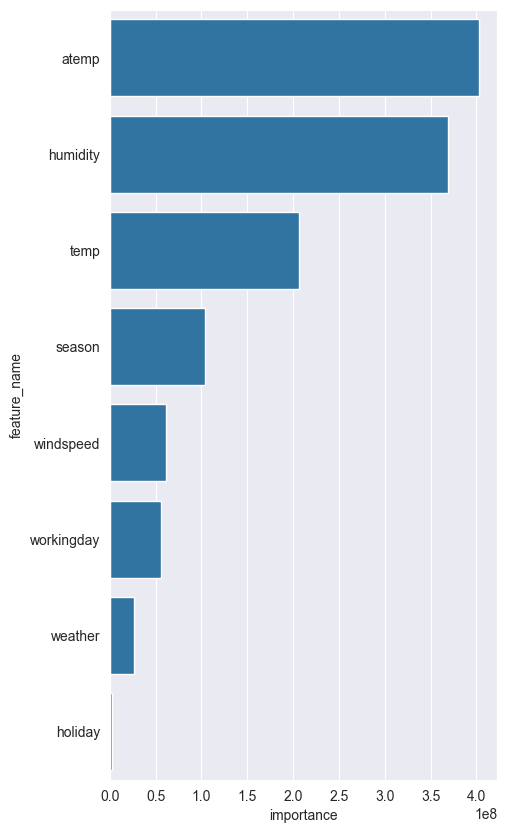

In [82]:
model = lgb.Booster(model_file=model_path)
importance_df = pd.DataFrame()

importance_df["importance"] = model.feature_importance(importance_type="gain")
importance_df["feature_name"] = model.feature_name()
importance_df = importance_df.sort_values("importance", ascending=False)

fig = plt.figure(figsize=(5, 10))
sns.barplot(data=importance_df, x="importance", y="feature_name")
plt.show()